# Modelo ARDL

###  Importacion de librerías requeridas

In [14]:
### Para el modelado
library(ARDL)

#Otros de manipulación de datos
library(forecast)
library(tseries)
library(tidyverse)
library(urca)
library(quantmod)
library(TSstudio)
library(dygraphs)
library(fUnitRoots)
library(dbplyr)
theme_set(theme_bw())
options(warn = - 1) 


Adjuntando el paquete: 'dbplyr'


The following objects are masked from 'package:dplyr':

    ident, sql




###  Importación de datos

In [5]:
### Descargar datos
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

##---------Obtener precios de yahoo finance:
precios <-function(simbolo)
{
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  datos<-na.omit(datos)
  datos <- datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

In [8]:
# Llamar la función para el activo en particular
precios("RYLD")
precios("TSLA")
precios("TM")
precios("GM")
s1= `RYLD`
s2=`TSLA`
i3=`TM`
i4=`GM`

In [9]:
length(s1)
length(s2)
length(i3)
length(i4)
datos <- merge.xts(s1, s2, i3, i4, join = "inner") %>% na.omit()
colnames(datos) <- c("RYLD", "TSLA", "TM", "GM")
str(datos)

[1] 933

[1] 933

[1] 933

[1] 933

An xts object on 2019-04-22 / 2022-12-30 containing: 
  Data:    double [933, 4]
  Columns: RYLD, TSLA, TM, GM
  Index:   Date [933] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2025-05-22 21:11:16"


### Partición de los datos

In [17]:
n <- nrow(datos)
n_test <- 47 #Equivalente al 5%
n_test
n_train <- n - n_test
n_train

train <- datos[1:n_train, ]
test <- datos[(n_train + 1):n, ]

[1] 47

[1] 886

### Prueba de estacionariedad

In [13]:
adf.test(s1)
adf.test(s2)
adf.test(i3)
adf.test(i4)


	Augmented Dickey-Fuller Test

data:  s1
Dickey-Fuller = -1.9681, Lag order = 9, p-value = 0.5918
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  s2
Dickey-Fuller = -0.82177, Lag order = 9, p-value = 0.9597
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  i3
Dickey-Fuller = -1.3187, Lag order = 9, p-value = 0.8667
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  i4
Dickey-Fuller = -1.3763, Lag order = 9, p-value = 0.8423
alternative hypothesis: stationary


Las series no son estacionarias, por lo que se aplica diferenciación.

In [15]:
adf.test(diff(s1)%>%na.omit())
adf.test(diff(s2)%>%na.omit())
adf.test(diff(i3)%>%na.omit())
adf.test(diff(i4)%>%na.omit())


	Augmented Dickey-Fuller Test

data:  diff(s1) %>% na.omit()
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(s2) %>% na.omit()
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(i3) %>% na.omit()
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(i4) %>% na.omit()
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Como se observa, las series son I(1), por lo que ARDL aplica.

## Modelo ARDL

In [36]:
#Comenzamos diferenciando los activos para luego, unirlos.
ryld.d=diff.xts(s1$RYLD.Close)[-1,]
tsla.d=diff.xts(s2$TSLA.Close)[-1,]
tm.d= diff.xts(i3$TM.Close)[-1,]
gm.d= diff.xts(i4$GM.Close)[-1,]

In [45]:
data_dif <- na.omit(merge(ryld.d, tsla.d, tm.d, gm.d))
colnames(data_dif) <- c("RYLD", "TSLA", "TM", "GM")

#### Partición de los datos diferenciados

In [46]:
n <- nrow(data_dif)
n_test <- 47
n_train <- n - n_test

train_dif <- data_dif[1:n_train, ]
test_dif <- data_dif[(n_train + 1):n, ]

In [49]:
train_df <- data.frame(
  DATE = index(train_dif), 
  coredata(train_dif)
)

In [50]:
colnames(train_df)

[1] "DATE" "RYLD" "TSLA" "TM"   "GM"

#### Modelo

In [51]:
#Se realiza una búsqueda tipo grid search:
#Selección automatica:
models <- auto_ardl(RYLD ~ TSLA + TM + GM, data = train_df, max_order = 6) #Usualmente el máx order es 6

In [52]:
#Revisemos el top 20 de los mejores modelos según su critrio de información de Akaike
models$top_orders

RYLD,TSLA,TM,GM,AIC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,0,2,-303.6096
2,0,1,2,-301.7375
2,0,0,3,-301.1561
3,0,0,2,-300.4202
2,1,1,2,-300.1354
3,0,0,3,-299.1801
3,0,1,2,-298.5569
2,1,2,2,-298.5564
2,2,2,2,-298.4703


El mejor modelo es ARDL(2,0,0,2). El autorregresivo de RYLD es 2 (esto implica que RYLD depende significativamente de sus propios dos rezagos), TSLA y TM no explican ningun rezago de RYLD, y GM explica a RYLD hasta con su rezago 2.

In [55]:
#Procedemos a construir el modelo de regresión con la mejor combinación.
mod1 <- ardl(RYLD ~ TSLA + TM + GM, data = train_df, order = c(2,0,0,2))
summary(mod1)


Time series regression with "ts" data:
Start = 3, End = 885

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.65417 -0.09652  0.01250  0.11147  0.81151 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0075646  0.0068274  -1.108  0.26818    
L(RYLD, 1)  -0.1215229  0.0308313  -3.942 8.74e-05 ***
L(RYLD, 2)   0.2174582  0.0307167   7.079 2.97e-12 ***
TSLA         0.0064068  0.0008919   7.184 1.45e-12 ***
TM           0.0277027  0.0034832   7.953 5.60e-15 ***
GM           0.0922961  0.0074005  12.472  < 2e-16 ***
L(GM, 1)     0.0136510  0.0075680   1.804  0.07161 .  
L(GM, 2)    -0.0212420  0.0075720  -2.805  0.00514 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2026 on 875 degrees of freedom
Multiple R-squared:  0.4551,	Adjusted R-squared:  0.4508 
F-statistic: 104.4 on 7 and 875 DF,  p-value: < 2.2e-

El modelo es globalmente significativo. RYLD tiene efecto autorregresivo negativo del primer rezago, y depende positivamente del segundo rezago. TSLA, TM y GM tienen efectos contemporáneos significativos, el primer rezago de GM es marginalmente significativo, y su segundor rezago tiene un efecto negativo.

In [56]:
# Para la interpretación, podemos imprimir los rezagos correspondientes de cada variable que explican la respuesta.
mod1$full_formula

RYLD ~ L(RYLD, 1) + L(RYLD, 2) + TSLA + TM + GM + L(GM, 1) + 
    L(GM, 2)

In [58]:
class(mod1)
names(mod1)

[1] "dynlm" "lm"    "ardl"

[1] "coefficients"   "residuals"      "effects"        "rank"          
 [5] "fitted.values"  "assign"         "qr"             "df.residual"   
 [9] "xlevels"        "call"           "terms"          "model"         
[13] "index"          "frequency"      "twostage"       "order"         
[17] "data"           "parsed_formula" "full_formula"

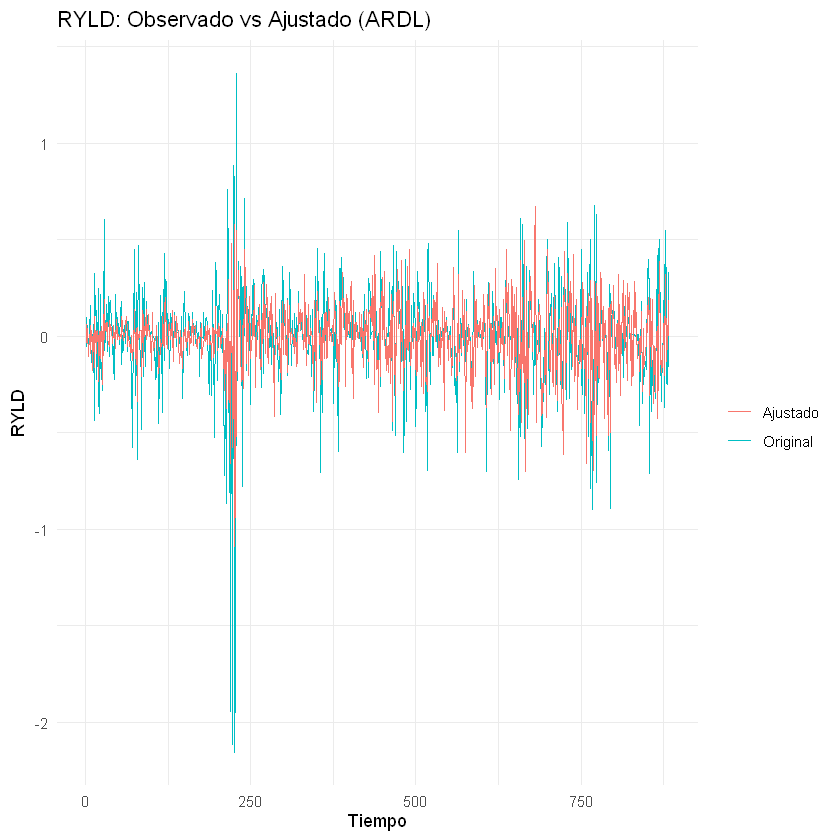

In [61]:
# Visualización del fit a la serie
fitted_vals <- mod1$fitted.values
pr_df_adj <- tail(pr_df, length(fitted_vals))  # igualamos las dimensiones, pues por los rezagos, no quedaban dimensiones iguales.

pr_df_adj$fitted <- fitted_vals  

library(ggplot2)
ggplot(pr_df_adj, aes(x = 1:nrow(pr_df_adj))) +
  geom_line(aes(y = RYLD, color = "Original")) +
  geom_line(aes(y = fitted, color = "Ajustado")) +
  labs(title = "RYLD: Observado vs Ajustado (ARDL)",
       x = "Tiempo",
       y = "RYLD",
       color = "") +
  theme_minimal()

#### A. Bound test para la verificacion de relaciones a largo término

In [91]:
#Guardamos el mejor modelo obtenido en la sección anterior
modelo <- models$best_model
#Realizamos la prueba de hipotesis: Hipotesis nula: no cointegración
bounds_f_test(modelo, case = 2) # el parametro "case" igual a 2 verifica si existe relaciones a largo término, con la combinación de (restricted constant o intercepto cte, no linear trend o sin tendencia determinista).


	Bounds F-test (Wald) for no cointegration

data:  d(RYLD) ~ L(RYLD, 1) + TSLA + TM + L(GM, 1) + d(L(RYLD, 1)) +     d(GM) + d(L(GM, 1))
F = 102.22, p-value = 1e-06
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


El estadístico F es muy alto y el valor p extremadamente bajo, lo que indica fuerte evidencia de cointegración. Esto implica que, aunque las series puedan ser no estacionarias individualmente, existe una combinación lineal entre ellas que es estacionaria, por lo que se mueven juntas en el largo plazo.

#### B. Mutiplicadores de largo y corto termino

In [93]:
#Multiplicadores a corto plazo
multipliers(modelo, type = "sr")

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),-0.007564596,0.0068274084,-1.107975,2.681772e-01
2,TSLA,0.006406842,0.0008918694,7.183610,1.452656e-12
3,TM,0.027702750,0.0034831727,7.953309,5.596722e-15
4,GM,0.092296104,0.0074004523,12.471684,5.633672e-33


En el corto plazo, los rendimientos de RYLD responden positivamente a variaciones contemporáneas en las acciones de TSLA, TM y GM, siendo GM la que ejerce el mayor efecto inmediato, seguida por TM y luego TSLA. Todas estas relaciones son estadísticamente significativas, lo que resalta una alta sensibilidad de RYLD a los movimientos del sector automotriz.

In [94]:
#Multiplicadores a largo plazo
multipliers(modelo)

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),-0.008367317,0.007546582,-1.108756,2.678401e-01
2,TSLA,0.007086707,0.001035872,6.841296,1.473871e-11
3,TM,0.030642441,0.004294701,7.134942,2.031390e-12
4,GM,0.093693611,0.013337503,7.024824,4.307007e-12


RYLD mantiene relaciones positivas y estadísticamente significativas a largo plazo con TSLA, TM y GM, siendo GM nuevamente la más influyente, seguida de TM y TSLA. Estos resultados refuerzan los hallazgos del corto plazo, indicando que el comportamiento del rendimiento del bono (RYLD) está estrechamente ligado al desempeño bursátil de los principales fabricantes automotrices, especialmente GM, tanto inmediata como estructuralmente.

### Predicción

    Point Forecast      Lo 80     Hi 80      Lo 95     Hi 95
886   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
887   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
888   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
889   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
890   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
891   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
892   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
893   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
894   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
895   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
896   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
897   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
898   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
899   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
900   -0.006819523 -0.2433341 0.2296951 -0.3685374 0.3548983
901   -0.006819523 -0.24

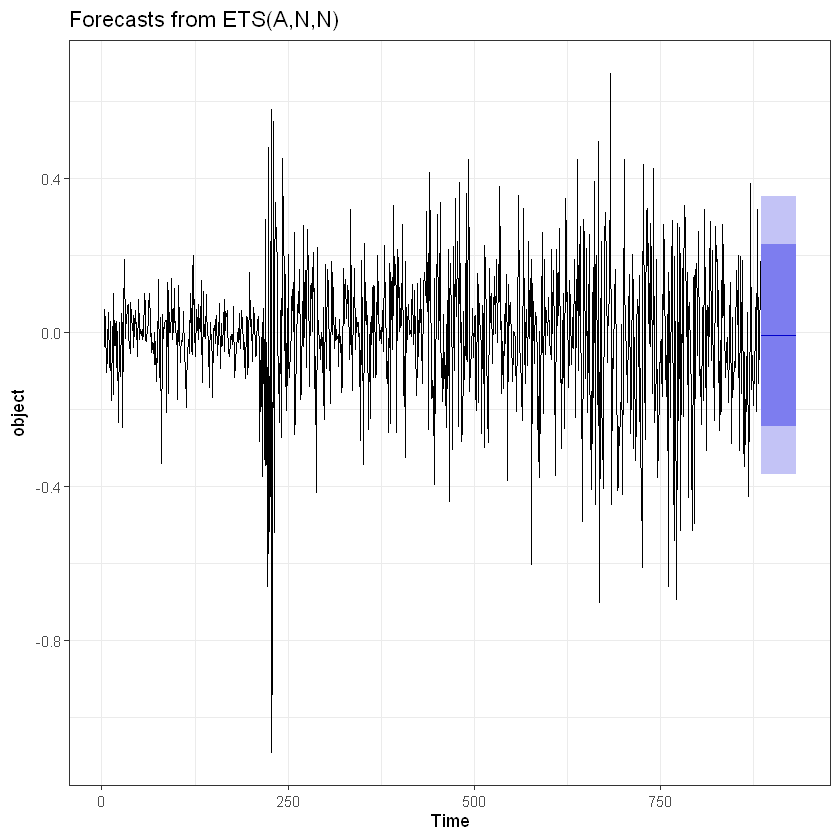

In [62]:
#### Predicción del primer modelo sin tendencia:
stats::predict(mod1$fitted.values, 47)

autoplot(predict(mod1$fitted.values, h=47))

**Métricas de desempeño**

In [73]:
# Hacer la predicción
h_test <- nrow(test)
test_pred_diff <- predict(mod1, n.ahead = h_test)

In [75]:
# Reconstruir niveles desde último valor de entrenamiento
last_val <- tail(pr_df$RYLD, 1)
pred_test_level <- cumsum(c(last_val, test_pred_diff))[-1]

In [82]:
# Emparejar dimensiones
real_test <- as.numeric(test$RYLD)
pred_level_test <- pred_test_level[1:length(real_test)]

In [83]:
real_test <- as.numeric(real_test)
pred_level_test <- as.numeric(pred_level_test)

rmse <- sqrt(mean((real_test - pred_level_test)^2))
mae <- mean(abs(real_test - pred_level_test))
mape <- mean(abs((real_test - pred_level_test)/real_test)) * 100

ss_res <- sum((real_test - pred_level_test)^2)
ss_tot <- sum((real_test - mean(real_test))^2)
r2 <- 1 - ss_res/ss_tot

cat("RMSE:", rmse, "\n")
cat("MAE:", mae, "\n")
cat("MAPE (%):", mape, "\n")
cat("R2:", r2, "\n")


RMSE: 19.95936 
MAE: 19.95597 
MAPE (%): 103.172 
R2: -4624.484 


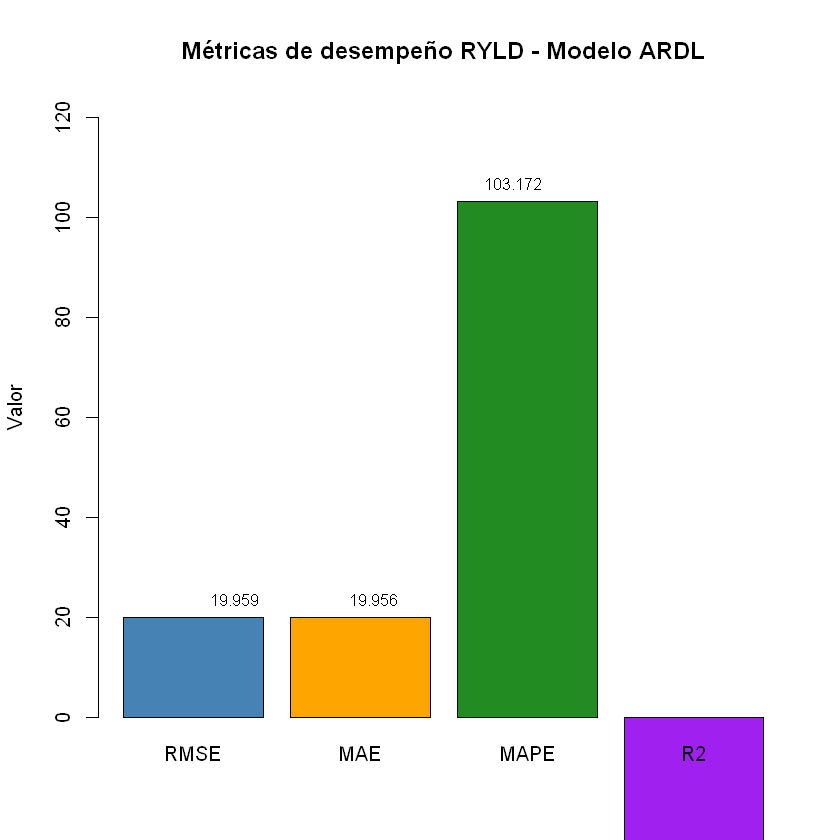

In [87]:
# Crear un vector con las métricas
metricas <- c(RMSE = rmse, MAE = mae, MAPE = mape, R2 = r2)

# Gráfico de barras
barplot(metricas,
        col = c("steelblue", "orange", "forestgreen", "purple"),
        main = "Métricas de desempeño RYLD - Modelo ARDL",
        ylab = "Valor",
        ylim = c(0, max(metricas) * 1.2))

# Añadir etiquetas con los valores sobre cada barra
text(x = seq_along(metricas),
     y = metricas,
     labels = round(metricas, 3),
     pos = 3, cex = 0.8, col = "black")

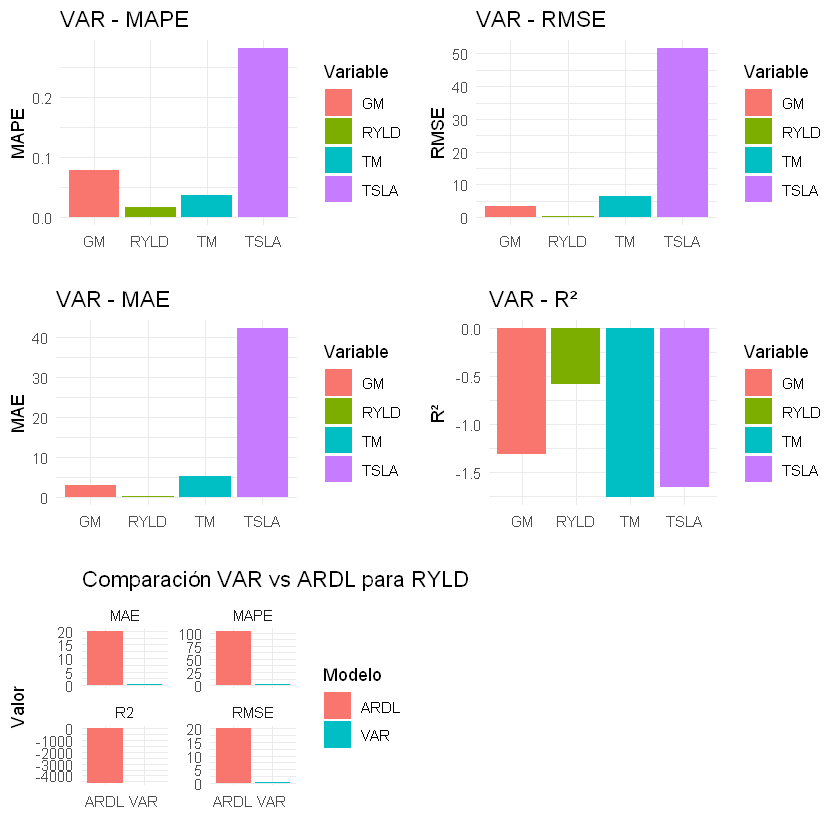

In [90]:
library(ggplot2)
library(gridExtra)
library(tidyr)  # Para pivot_longer

# Métricas para VAR
var_metrics <- data.frame(
  Variable = c("RYLD", "TSLA", "TM", "GM"),
  MAPE = c(0.01636031, 0.2821014, 0.03750074, 0.07897345),
  RMSE = c(0.3698066, 51.67979, 6.559112, 3.316087),
  MAE = c(0.318948, 42.33578, 5.37977, 3.054765),
  R2 = c(-0.5878642, -1.657756, -1.76465, -1.310598)
)

# Métricas ARDL solo para RYLD
ardl_metrics <- data.frame(
  Modelo = c("VAR", "ARDL"),
  RMSE = c(0.3698066, 19.95936),
  MAE = c(0.318948, 19.95597),
  MAPE = c(1.636031, 103.172),  # Convertimos MAPE VAR a %
  R2 = c(-0.5878642, -4624.484)
)

# Crear gráficos individuales por métrica para VAR
plot_mape <- ggplot(var_metrics, aes(x = Variable, y = MAPE, fill = Variable)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "VAR - MAPE", y = "MAPE", x = "")

plot_rmse <- ggplot(var_metrics, aes(x = Variable, y = RMSE, fill = Variable)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "VAR - RMSE", y = "RMSE", x = "")

plot_mae <- ggplot(var_metrics, aes(x = Variable, y = MAE, fill = Variable)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "VAR - MAE", y = "MAE", x = "")

plot_r2 <- ggplot(var_metrics, aes(x = Variable, y = R2, fill = Variable)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "VAR - R²", y = "R²", x = "")

# Preparar datos para gráfico comparativo con todas las métricas
ardl_long <- ardl_metrics %>%
  pivot_longer(cols = c("RMSE", "MAE", "MAPE", "R2"),
               names_to = "Metrica",
               values_to = "Valor")

# Gráfico comparativo VAR vs ARDL con todas las métricas
plot_compare <- ggplot(ardl_long, aes(x = Modelo, y = Valor, fill = Modelo)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_wrap(~Metrica, scales = "free_y") +  # Facet para cada métrica con eje Y independiente
  theme_minimal() +
  labs(title = "Comparación VAR vs ARDL para RYLD", y = "Valor", x = "")

# Mostrar todo junto
grid.arrange(plot_mape, plot_rmse, plot_mae, plot_r2, plot_compare, ncol = 2)
